# Определение возраста покупателей

Сетевой супермаркет «Хлеб-Соль» внедряет систему компьютерного зрения для обработки фотографий покупателей. Фотофиксация в прикассовой зоне поможет определять возраст клиентов, чтобы:

- анализировать покупки и предлагать товары, которые могут заинтересовать покупателей этой возрастной группы;

- контролировать добросовестность кассиров при продаже алкоголя.

**Цель**

Построить модель, которая по фотографии определит приблизительный возраст человека, используя набор фотографий людей с указанием возраста.

**Задачи**

В рамках работы предстоит:

- провести исследовательский анализ данных, чтобы выявить аномалии, выбросы, пропуски и т.д.

- выбрать подходящую нейросетевую модель и обучить её

- подобрать параметры модели, чтобы MAE на тестовой выборке не превышала 8 (желательно 7).

- проанализировать результаты и дать рекомендации для заказчика

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from PIL import Image

from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet import ResNet50

2025-08-29 10:40:49.225723: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1756453249.236900   14014 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1756453249.240385   14014 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1756453249.250056   14014 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1756453249.250066   14014 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1756453249.250067   14014 computation_placer.cc:177] computation placer alr

## Исследовательский анализ данных

In [2]:
path_base = ''
path_img = path_base + 'final_files/'

In [3]:
faces_info = pd.read_csv(path_base + 'labels.csv')
faces_info.info()
faces_info.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7591 entries, 0 to 7590
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   file_name  7591 non-null   object
 1   real_age   7591 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 118.7+ KB


,file_name,real_age
0,000000.jpg,4
1,000001.jpg,18
2,000002.jpg,80
3,000003.jpg,50
4,000004.jpg,17


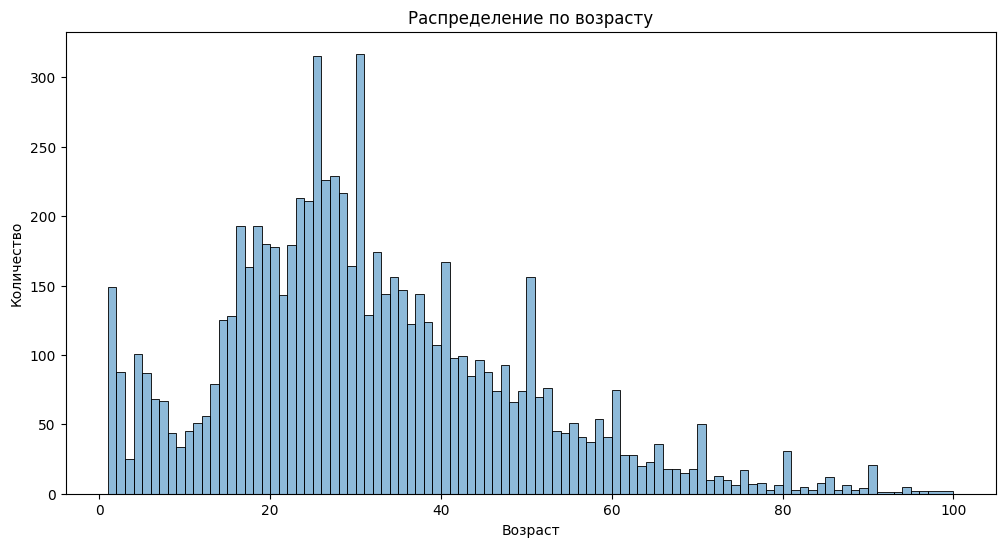

In [4]:
plt.figure(figsize=(12, 6))
sns.histplot(
    faces_info, 
    legend=False, 
    bins=np.sort(faces_info.real_age.unique())
)
plt.title('Распределение по возрасту')
plt.xlabel('Возраст')
plt.ylabel('Количество')
plt.show()

Примерно 7500 образцов, наибольшее количество людей 20-30 лет, длинный хвост справа + довольно много совсем детских фото.

Посмотрим на первые 15.

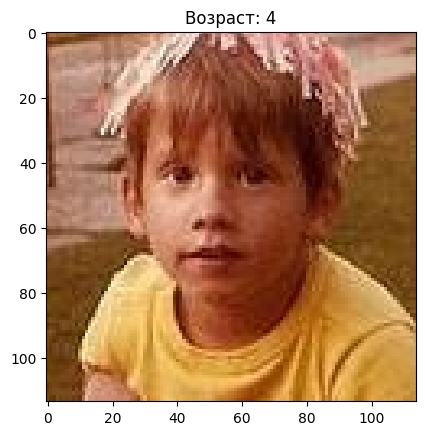

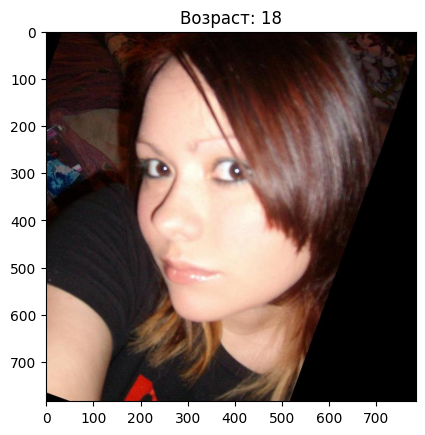

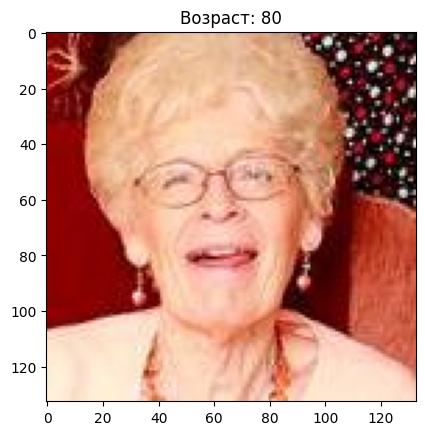

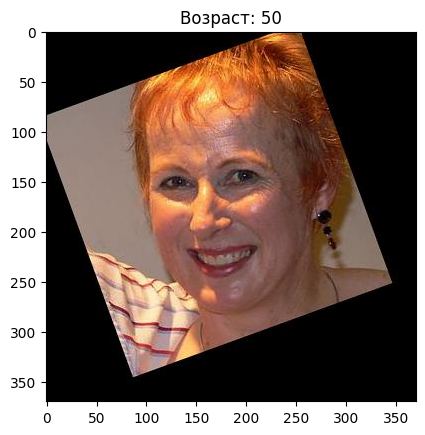

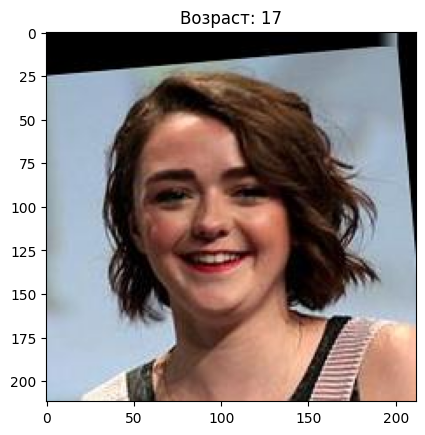

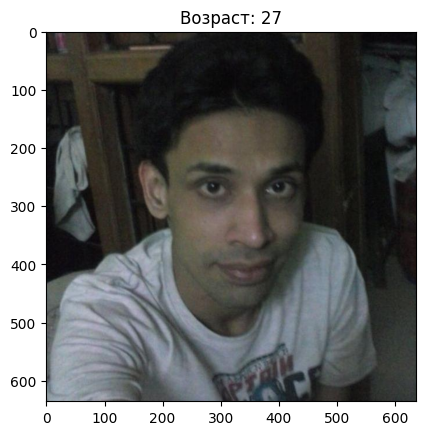

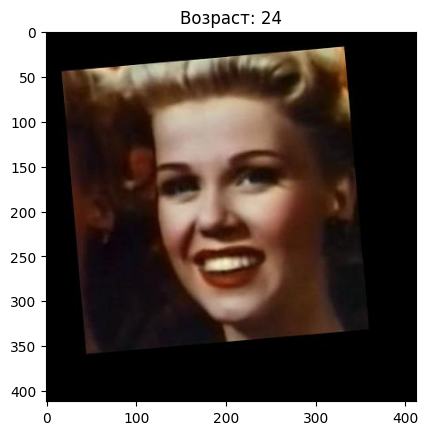

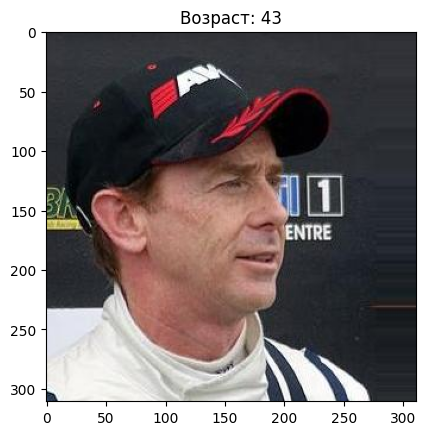

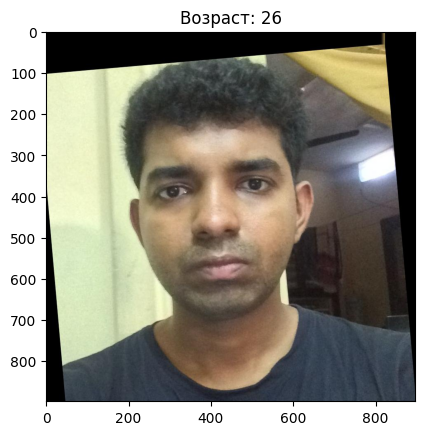

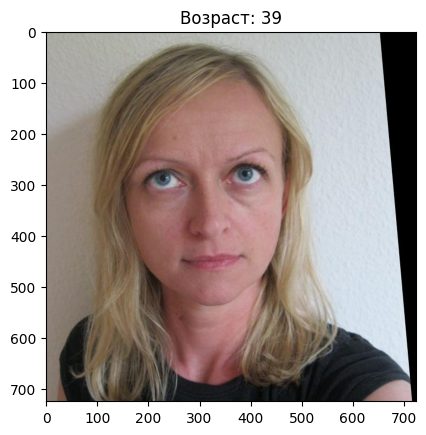

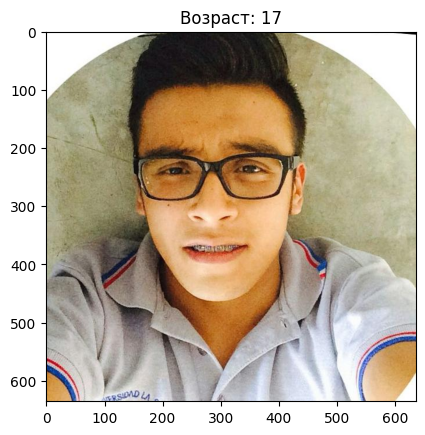

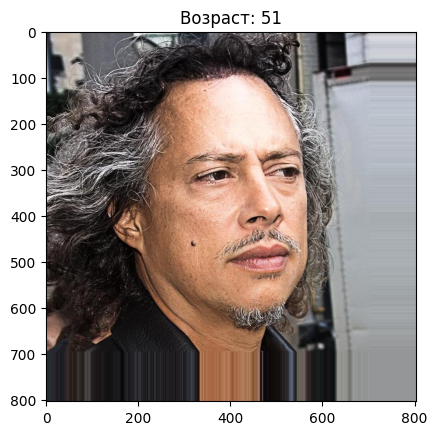

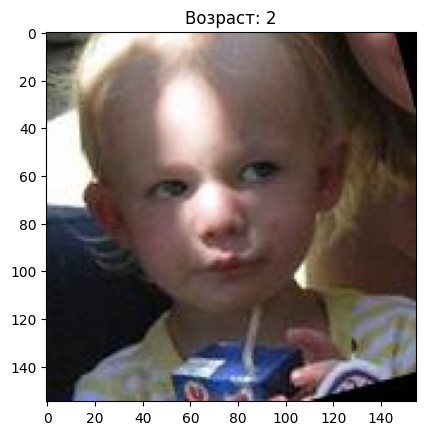

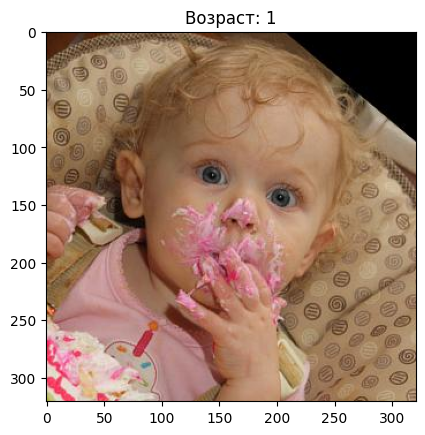

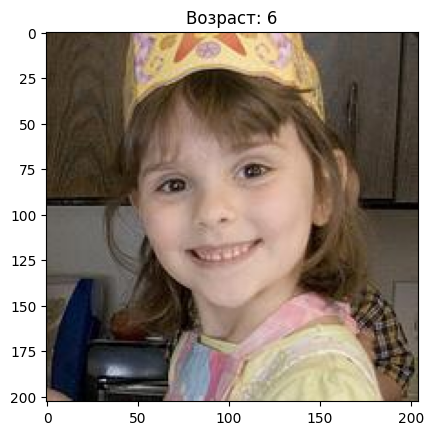

In [5]:
for i in range(15):
    fname = faces_info.file_name[i]
    img = Image.open(path_img + fname)
    plt.imshow(np.array(img))
    plt.title(f'Возраст: {faces_info.real_age[i]}')
    plt.show()

Мэйси Уильямс и Кирк Хэмметт)

Вроде бы всё в порядке - можно освоить flow_from_dataframe и попытаться обучить модель.


### Итог 
В качестве выводов сказал бы следующее:
 
- в данных пропусков и аномалий нет

- распределение по возрасту выглядит адекватным 

- разметка у фото также в порядке, если судить по первым 15

- уже у первых 15 есть разные разрешения - надо приводить к одному

- в остальном данные готовы для дальнейшей работы 


## Обучение модели

In [6]:
def load_data(
    path,
    tp
):
    
    data_gen = ImageDataGenerator(
        validation_split=0.25,
        rescale=1./255,
        horizontal_flip=True
    )
    
    faces_info = pd.read_csv(path + 'labels.csv')
    path_img = path + 'final_files/'
    
    data_gen_flow = data_gen.flow_from_dataframe(
        faces_info,
        path_img,
        x_col='file_name',
        y_col='real_age',
        class_mode='raw',
        target_size=(224, 224),
        batch_size=32,
        seed=12345,
        subset=tp
    )
    
    return data_gen_flow

In [7]:
input_shape = (224, 224, 3)

backbone = ResNet50(
    input_shape=input_shape,
    weights='imagenet',
    include_top=False
)
    
model = Sequential()
optimizer = Adam(learning_rate=0.0005)
    
model.add(backbone)
model.add(GlobalAveragePooling2D())
model.add(Dense(units=1, activation='relu'))

model.compile(loss='mse', optimizer=optimizer, metrics=['mae'])

I0000 00:00:1756453252.169130   14014 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 10027 MB memory:  -> device: 0, name: NVIDIA GeForce GTX 1080 Ti, pci bus id: 0000:2b:00.0, compute capability: 6.1


In [8]:
train_data = load_data('', 'training')
test_data = load_data('', 'validation')
batch_size = None
epochs = 10
steps_per_epoch = None
validation_steps = None

Found 5694 validated image filenames.
Found 1897 validated image filenames.


In [9]:
model.fit(
    train_data, 
    validation_data=test_data,
    batch_size=batch_size,
    epochs=epochs,
    steps_per_epoch=steps_per_epoch,
    validation_steps=validation_steps,
    verbose=2, 
    shuffle=True
)

Epoch 1/10


/home/sergey/.jupyter_tf/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
I0000 00:00:1756453266.111250   14124 service.cc:152] XLA service 0x725688002180 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1756453266.111266   14124 service.cc:160]   StreamExecutor device (0): NVIDIA GeForce GTX 1080 Ti, Compute Capability 6.1
2025-08-29 10:41:06.579215: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1756453268.907910   14124 cuda_dnn.cc:529] Loaded cuDNN version 90300
2025-08-29 10:41:10.129126: I external/local

178/178 - 79s - 444ms/step - loss: 201.3699 - mae: 10.5895 - val_loss: 413.2149 - val_mae: 15.3171
Epoch 2/10
178/178 - 34s - 193ms/step - loss: 112.5263 - mae: 8.0394 - val_loss: 406.6464 - val_mae: 15.1543
Epoch 3/10
178/178 - 35s - 195ms/step - loss: 91.7686 - mae: 7.2598 - val_loss: 390.7469 - val_mae: 14.8863
Epoch 4/10
178/178 - 35s - 199ms/step - loss: 78.6668 - mae: 6.7203 - val_loss: 232.9630 - val_mae: 11.4602
Epoch 5/10
178/178 - 35s - 194ms/step - loss: 61.8591 - mae: 5.9834 - val_loss: 118.3077 - val_mae: 8.1757
Epoch 6/10
178/178 - 34s - 193ms/step - loss: 53.1236 - mae: 5.5042 - val_loss: 96.2500 - val_mae: 7.3511
Epoch 7/10
178/178 - 34s - 192ms/step - loss: 41.7720 - mae: 4.9582 - val_loss: 84.1725 - val_mae: 6.9452
Epoch 8/10
178/178 - 34s - 194ms/step - loss: 37.1024 - mae: 4.6499 - val_loss: 74.9465 - val_mae: 6.5365
Epoch 9/10
178/178 - 35s - 195ms/step - loss: 30.9229 - mae: 4.2334 - val_loss: 82.4671 - val_mae: 6.8287
Epoch 10/10
178/178 - 34s - 193ms/step - loss

## Анализ обученной модели

В использованном наборе фото около 7500 человек. 
Выборка была поделена в соотношении 3:1 на обучающую и тестовую + изображения были приведены к разрешению 224х224. 
Для предсказания возраста была обучена ResNet50, у которой выход был заменён на один нейрон с выпрямленной линейной активацией.
В качестве старта были взяты веса ImageNet.
Так как изображений много, в процедуре обучения фитовались все веса, а не только выход.
В качестве функции потерь была использована MSE, а для оценки качества - MAE.
На обучающей MAE составила 4.1 года, а на тестовой - 6.8, то есть модель немного переобучилась.
Однако, целевые MAE=7 на тестовой достигнуты.

С учётом точности модели закачику рекомендуется:

- делить покупателей на группы достаточно большие группы (не меньше 10-12 лет) 
- у всех, кого модель определит моложе 25, требовать документы при покупке соответствующих товаров